In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import os
import sys
import ast
from textblob import TextBlob
import string
import spacy
nlp = spacy.load('en_core_web_sm')
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ZBOOK\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
path = "datasets/"
filenames = glob.glob(path + "\*.xlsx")
print(f"File names {filenames}")

File names ['datasets\\conventional vs organic.xlsx', 'datasets\\organic agriculture.xlsx', 'datasets\\organic food.xlsx', 'datasets\\sustainable farming.xlsx']


In [4]:
outputxlsx = pd.DataFrame()

for file in filenames:
    df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True, sort=False)
    outputxlsx = pd.concat([outputxlsx, df], )

print(outputxlsx)

     Unnamed: 0                                              topic content  \
0             0                                Buying organic food     NaN   
1             1  Harvesting your own food, 100% organic in a sp...     NaN   
2             2  TIL there is broad scientific consensus that f...     NaN   
3             3  Legal marijuana is the fastest-growing industr...     NaN   
4             4                         Store Cat Food vs Homemade     NaN   
..          ...                                                ...     ...   
224         224  || Awareness campaign for sustainable farming ...     NaN   
225         225  The Oscars Are Going (Mostly) Meatless This Ye...     NaN   
226         226  Local and sustainable and regeneratively-farme...     NaN   
227         227  Artificial Intelligence for Ethical and Sustai...     NaN   
228         228  My local Kroger finally carries cherry tomatoe...     NaN   

                         time            poster  \
0    2014-08

In [5]:
full_data = outputxlsx.drop(columns="Unnamed: 0")
full_data.columns

Index(['topic', 'content', 'time', 'poster', 'comments', 'source'], dtype='object')

In [6]:
content_data = full_data[["topic", "content", "comments", "time"]] \
    .dropna() \
    .reset_index() \
    .drop(columns="index") \
    .drop_duplicates()

content_data

,topic,content,comments,time
0,I can't think of a single person I've ever gon...,Yet everyone in ethical veganism debates says ...,"['I dated a guy who said the ol ""I only eat me...",2021-11-24T14:33:48.594Z
1,CMV: All grocery stores should be forced by la...,"I know forced sounds extreme, but so is homele...","['Only 29% of food waste is from businesses, t...",2021-12-14T00:55:11.463Z
2,Do you leave food out all the time or have sch...,I just leave food and water out for my cats so...,"['', 'Mine get some tinned food for breakfast ...",2023-05-29T19:59:23.578Z
3,"If you have food allergies, are there any that...",I was just talking about this and the question...,"[""Yes, potentially. We have seen both tree nut...",2019-06-22T06:04:32.466Z
4,AITA for refusing to pay for my boyfriend's fo...,I have an Instagram account dedicated to photo...,['This thread is now locked due to an excess o...,2023-05-23T15:36:55.919Z
...,...,...,...,...
258,Organic and Sustainable farming from Miditer,The journey from seed to table can be a long o...,[],2022-11-12T18:49:44.139Z
259,Any volunteering organisations specifically fo...,I was wondering if anyone knows of volunteerin...,['Can anybody explain why wwoofing is more tha...,2022-09-17T17:25:24.990Z
260,Personal Challenge: self-sustaining farm,Been playing my latest save for a while and th...,"['Dude I should totally try this.', ""It's been...",2022-06-27T18:06:43.328Z
261,Icelandic Greenhouse Experience: Unveiling the...,Step into the enchanting world of Icelandic gr...,[],2023-07-13T06:52:34.975Z


In [7]:
## Descriptive Stats

content_data.info()

content_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   topic     263 non-null    object
 1   content   263 non-null    object
 2   comments  263 non-null    object
 3   time      263 non-null    object
dtypes: object(4)
memory usage: 8.3+ KB


,topic,content,comments,time
count,263,263,263,263
unique,208,217,158,262
top,$SRT #Saratoga #SeedRound #Presale #FairLaunch...,This is a powerful project! The team is in clo...,[],2015-08-14T00:31:53.534Z
freq,20,13,102,2


In [8]:
## Data Cleaning
content_data.columns

content_data.columns = content_data.columns.str.strip()
print(content_data.columns)

Index(['topic', 'content', 'comments', 'time'], dtype='object')


In [9]:
## Convert time column to datetime format
content_data['timestamp'] = pd.to_datetime(content_data["time"])

## Extract date and time columns resp
content_data['date'] = content_data['timestamp'].dt.date
content_data['time'] = content_data['timestamp'].dt.time

## Drop unnecessary columns
content_data = content_data.drop(['timestamp'], axis=1)
content_data.head()

,topic,content,comments,time,date
0,I can't think of a single person I've ever gon...,Yet everyone in ethical veganism debates says ...,"['I dated a guy who said the ol ""I only eat me...",14:33:48.594000,2021-11-24
1,CMV: All grocery stores should be forced by la...,"I know forced sounds extreme, but so is homele...","['Only 29% of food waste is from businesses, t...",00:55:11.463000,2021-12-14
2,Do you leave food out all the time or have sch...,I just leave food and water out for my cats so...,"['', 'Mine get some tinned food for breakfast ...",19:59:23.578000,2023-05-29
3,"If you have food allergies, are there any that...",I was just talking about this and the question...,"[""Yes, potentially. We have seen both tree nut...",06:04:32.466000,2019-06-22
4,AITA for refusing to pay for my boyfriend's fo...,I have an Instagram account dedicated to photo...,['This thread is now locked due to an excess o...,15:36:55.919000,2023-05-23


In [42]:
cont_data = pd.read_csv("organic food headlines.csv")

content_data = cont_data.drop(columns='Unnamed: 0')

content_data

,title,subreddit,score,id,url,comments,body,created
0,finding organic food in USA?,organic,5,14rw5it,https://www.reddit.com/r/organic/comments/14rw...,13,"hey guys, soon I’m going on a holiday to USA, ...",1.688613e+09
1,Organic Food,OrganicGardening,2,13h8hnm,https://www.reddit.com/r/OrganicGardening/comm...,0,"If you buy **organic food**, in small or large...",1.684059e+09
2,Why do many Organic Food products have Non-GMO...,organic,5,10fjq30,https://www.reddit.com/r/organic/comments/10fj...,23,Correct me if I'm wrong but doesn't Organic im...,1.674079e+09
3,Which supermarket/store is best to buy healthy...,organic,9,y9jdcx,https://www.reddit.com/r/organic/comments/y9jd...,13,Which supermarket/store in the US is best to b...,1.666325e+09
4,Should I be concerned about the coconut coir M...,gardening,8,us1axf,https://www.reddit.com/gallery/us1axf,27,NaN,1.652836e+09
...,...,...,...,...,...,...,...,...
233,Organic Food - Vive Health,OrganicFarming,0,2lym0b,http://www.vivehealth.com.au/Organic-Foods-Who...,0,NaN,1.415710e+09
234,"True organic food benefits environment, sustai...",OrganicFarming,2,1bx0g5,http://www.goldengatexpress.org/2013/04/07/tru...,0,NaN,1.365429e+09
235,New California bill gives fresh produce and qu...,OrganicFarming,1,2i7ywd,http://www.californiality.com/2014/10/governor...,0,NaN,1.412369e+09
236,"10 Great Reasons Why Local, Organic Food is th...",OrganicFarming,1,23elni,http://www.onegreenplanet.org/natural-health/w...,0,NaN,1.397872e+09


In [65]:
## Data Preprocessing

def handle_contractions(text):
    contractions = {
        "n't": " not",
        "'s" : " is",
        "'d" : " would",
        "'ve" : " have",
        "'re": " are",
        "'ll": " will",
        "'m": " am"
    }
    
    words = text.split()
    for i in range(len(words)):
        if words[i] in contractions:
            words[i] = contractions[words[i]]
    return ' '.join(words)

## Preprocessing Text Data
def preprocess_text(text):
    text = text.lower()
    
    ## remove numbers from the text
    text = re.sub(r"\d+", '', text)
    
    ## removing punctuations
    text = ''.join([char for char in text if char not in string.punctuation])
    
    ## Tokenize text
    tokens = word_tokenize(text)
    
    ## Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    
    ## Remove contractions from words
    text = handle_contractions(' '.join(tokens))
    
    ## Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text)]
    
    return ' '.join(tokens)

content_data['processed_content'] = content_data['title'].apply(preprocess_text)



In [45]:
content_data = content_data.drop_duplicates()
content_data.describe()

,score,comments,created
count,238.000000,238.000000,2.380000e+02
mean,10.016807,2.537815,1.503864e+09
std,11.131726,4.440492,9.225019e+07
min,0.000000,0.000000,1.284478e+09
25%,2.000000,0.000000,1.429407e+09
50%,6.000000,1.000000,1.490143e+09
75%,13.750000,3.000000,1.575920e+09
max,75.000000,27.000000,1.688613e+09


In [46]:
def percentage(val, total):
    return (val / total) * 100

In [47]:


def get_sentiment_scores(text_array):
    
    positive = 0
    negative = 0
    neutral = 0

    scores = []

    content_list = []

    positive_list = []
    negative_list = []
    neutral_list = []

    contents = text_array

    for content in contents:
        #print(content)
        content_list.append(content)
        score = SentimentIntensityAnalyzer().polarity_scores(content)
        
        neg_score = score['neg']
        pos_score = score['pos']
        neu_score = score['neu']    
        
        scores.append([neg_score, pos_score, neu_score])
        
        if neg_score > pos_score:
            negative_list.append(content)
            negative += 1
        elif neg_score < pos_score:
            positive_list.append(content)
            positive += 1
        elif neg_score == pos_score:
            neutral_list.append(content)
            neutral += 1
            
    positive = percentage(positive, len(contents))
    negative = percentage(negative, len(contents))
    neutral = percentage(neutral, len(contents))

    positive = format(positive, '.1f')
    negative = format(negative, '.1f')
    neutral = format(neutral, '.1f')
    
    
    return {
        'scores': scores,
        'positive': positive,
        'negative': negative,
        'neutral' : neutral
    }

In [48]:
## Polarity and Subjectivity Scores for contents

subjectivity_score = content_data['processed_content'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
polarity_score = content_data['processed_content'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [49]:
sentiment_scores = get_sentiment_scores(content_data['processed_content'])

scores_data = pd.DataFrame(sentiment_scores['scores'], columns=["neg", "pos", "neu"])
scores_data.reset_index()

content_data.reset_index()

# print(content_data)
content_score_data = content_data.merge(scores_data, right_index=True, left_index=True)
content_score_data['subjectivity'] = subjectivity_score
content_score_data['polarity'] = polarity_score
content_score_data.sample(3)

,title,subreddit,score,id,url,comments,body,created,processed_content,neg,pos,neu,subjectivity,polarity
30,Organic Food Sales Soar During Pandemic,organic,30,nm3z50,https://www.thefencepost.com/news/ota-organic-...,1,NaN,1.622109e+09,organic food sale soar pandemic,0.000,0.0,1.000,0.000000,0.000000
95,You can cut your cancer risk by eating organic...,organic,20,9qguox,https://www.cnn.com/2018/10/22/health/organic-...,0,NaN,1.540235e+09,cut cancer risk eating organic new study say a...,0.442,0.0,0.558,0.863636,0.034091
147,How a Mexican-American Farmer Is Making Organi...,organic,15,5a89hj,http://www.takepart.com/article/2016/10/30/aff...,0,NaN,1.477861e+09,mexicanamerican farmer making organic food acc...,0.000,0.0,1.000,0.375000,0.375000


In [50]:
## Attach Sentiment label
content_score_data.loc[content_score_data['neg'] > content_score_data['pos'], "sentiment_label"] = "negative"
content_score_data.loc[content_score_data['pos'] > content_score_data['neg'], "sentiment_label"] = "positive"
content_score_data.loc[content_score_data['neg'] == content_score_data['pos'], "sentiment_label"] = "neutral"

content_score_data.sample(5)

,title,subreddit,score,id,url,comments,body,created,processed_content,neg,pos,neu,subjectivity,polarity,sentiment_label
162,"Has anyone here heard Science VS episode ""Orga...",OrganicFarming,2,7jbynx,https://www.reddit.com/r/OrganicFarming/commen...,1,Has anyone here heard Gimlet Media's Science V...,1.513097e+09,anyone heard science v episode organic food,0.000,0.0,1.000,0.000000,0.000000,neutral
120,"Has anyone here heard Science VS episode ""Orga...",organic,2,7jbt1q,https://www.reddit.com/r/organic/comments/7jbt...,4,Has anyone here heard Gimlet Media's Science V...,1.513096e+09,anyone heard science v episode organic food,0.000,0.0,1.000,0.000000,0.000000,neutral
27,Organic food revolution in Sri Lanka threatens...,farming,4,phk1oz,https://www.aljazeera.com/news/2021/9/1/organi...,0,NaN,1.630726e+09,organic food revolution sri lanka threatens te...,0.271,0.0,0.729,0.000000,0.000000,negative
86,Is the organic food at Aldi legit?,organic,3,8zl19q,https://www.reddit.com/r/organic/comments/8zl1...,3,I recently moved neighborhoods and the only pl...,1.531833e+09,organic food aldi legit,0.000,0.0,1.000,0.000000,0.000000,neutral
7,Scathing Audit by US Office Inspector General ...,organic,28,ud6rko,https://www.usda.gov/sites/default/files/01601...,8,NaN,1.651075e+09,scathing audit u office inspector general usda...,0.162,0.0,0.838,0.603571,-0.139286,negative


In [51]:
## Descriptive Statistics

sentiment_counts = content_score_data['sentiment_label'].value_counts()
average_sentiment_score = content_score_data['polarity'].mean()

print("Total Sentiment counts")
print(sentiment_counts)
print("----------------")
print("Average Sentiment score")
print(average_sentiment_score)


Total Sentiment counts
sentiment_label
neutral     115
positive     75
negative     48
Name: count, dtype: int64
----------------
Average Sentiment score
0.06721335503898529


c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


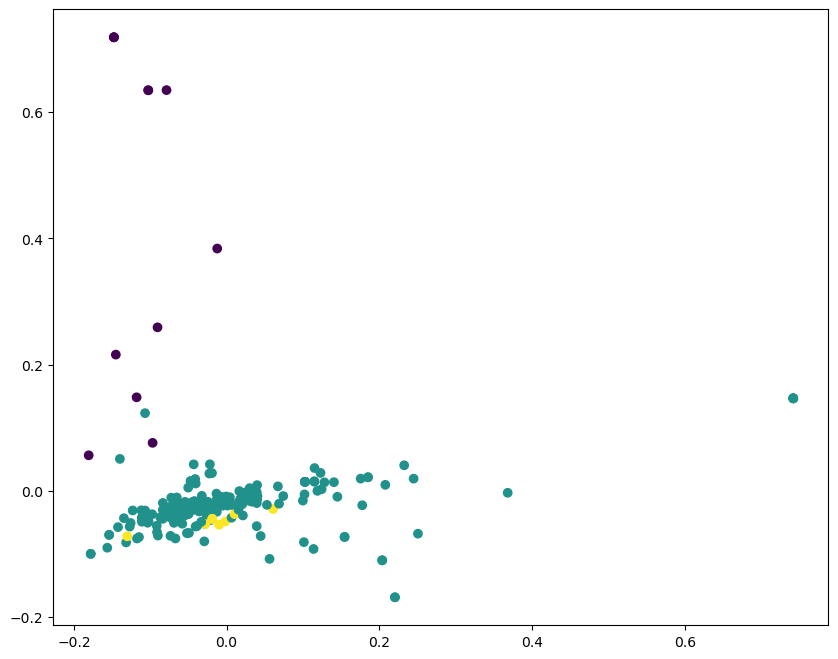

In [52]:
## Text Clustering to group similar content together

vectorizer = TfidfVectorizer()

## Apply this vectorizer on the processed content
tfidf_matrix = vectorizer.fit_transform(content_score_data['processed_content'])

## Kmeans clustering on the matrix data
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=23)
kmeans.fit(tfidf_matrix)

## Assigning cluster labels
content_score_data['cluster'] = kmeans.labels_

## Using PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10,8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=content_score_data['cluster'], cmap='viridis')
plt.show()

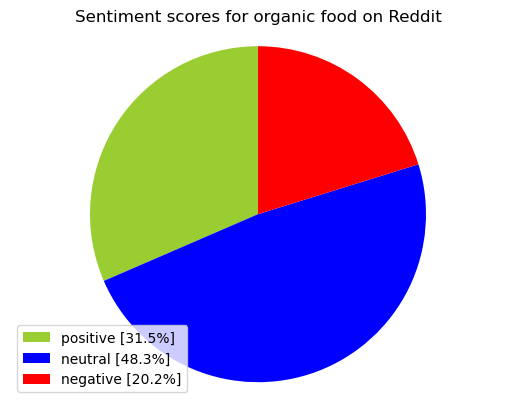

In [53]:
positive = sentiment_scores['positive']
negative = sentiment_scores['negative']
neutral = sentiment_scores['neutral']

labels = [f'positive [{str(positive)}%]', f'neutral [{str(neutral)}%]', f'negative [{str(negative)}%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue', 'red']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.style.use("default")
plt.legend(labels)
plt.title("Sentiment scores for organic food on Reddit")
plt.axis('equal')
plt.show()


c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


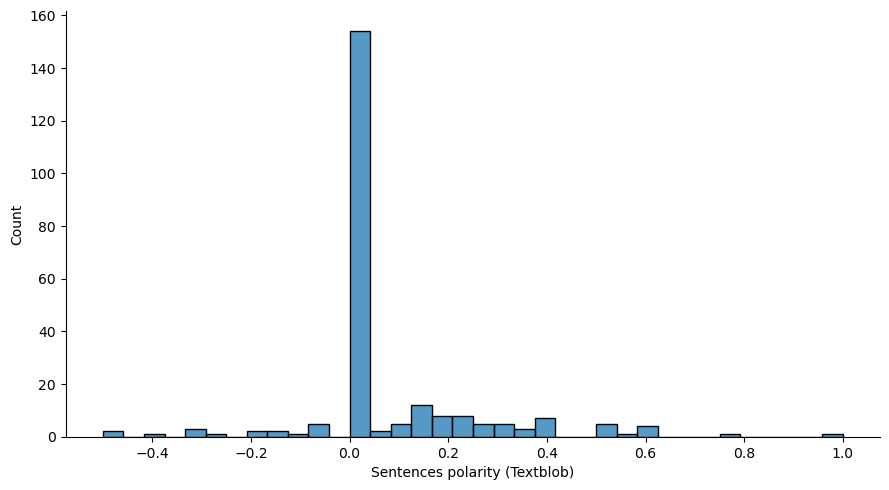

In [54]:
# Polarity score distribution

sns.displot(content_score_data["polarity"], height=5, aspect=1.8)
plt.xlabel("Sentences polarity (Textblob)")
plt.show()

In [55]:
## Word Frequency and Word Cloud

## Text Preprocessing
## Tokenizer
def process_content_text(text):
    
    tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
    sentence = " ".join(text)
    tokenized_contents = tokenizer.tokenize(sentence)

    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in tokenized_contents if len(token) > 1]
    
    stopwords = nltk.corpus.stopwords.words("english")

    return [word for word in text if word not in stopwords]


# tokens = [tokenizer.tokenize(t) for t in contents_cleaned]
# all_tokens = [token for sublist in tokens for token in sublist]
# tokens

# all = nlp(sentence)
# cleaned_tokens = [token.lower() for token in all_tokens]
# cleaned_tokens

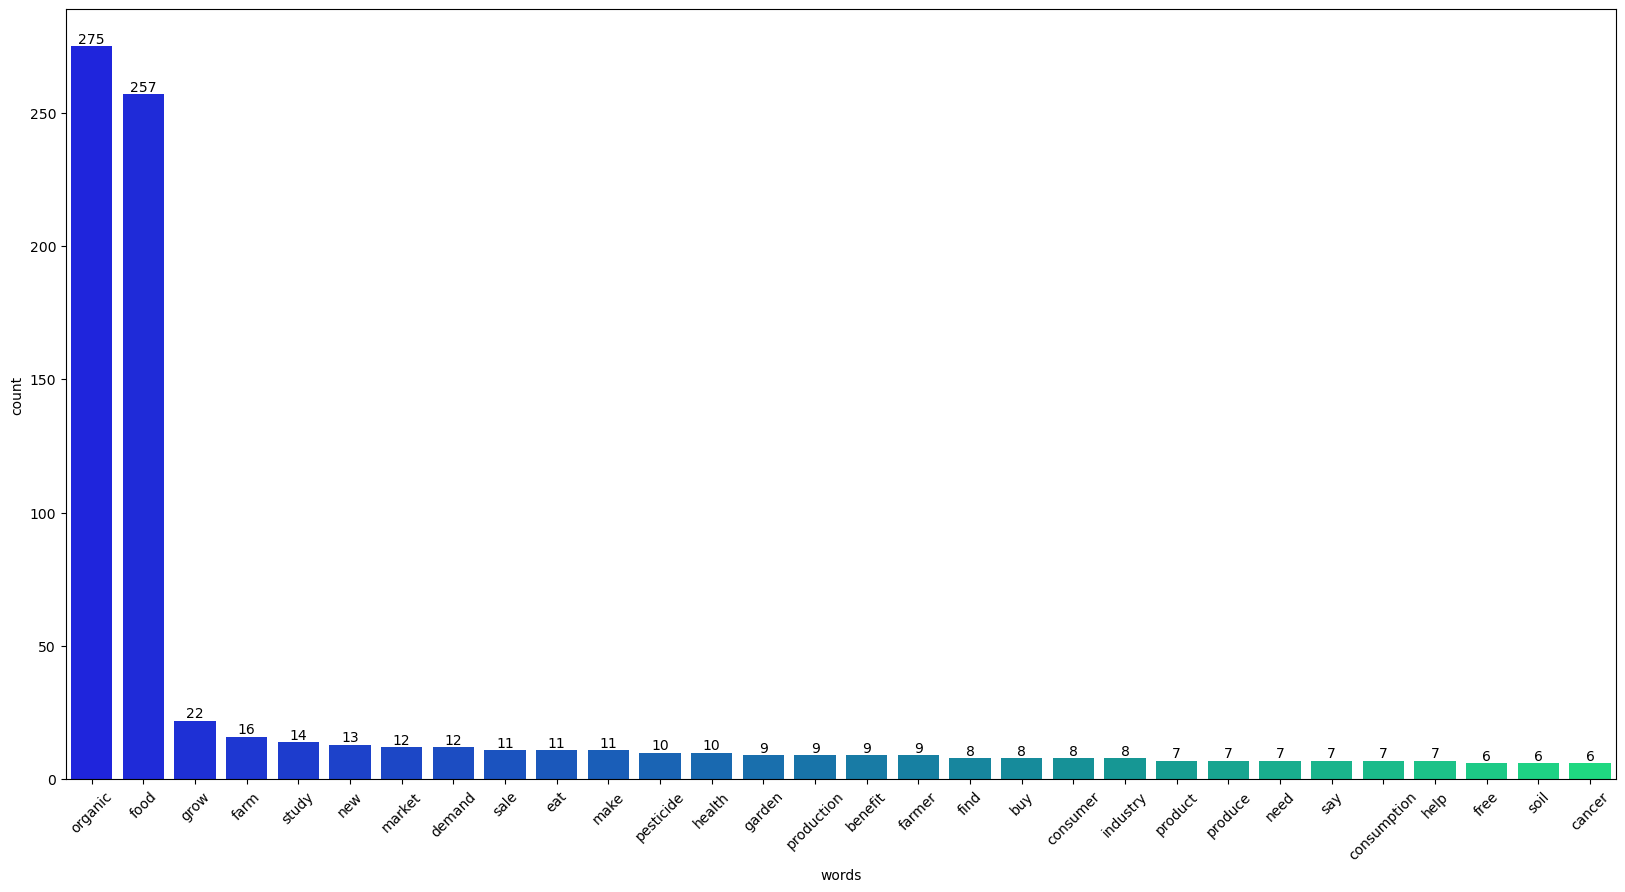

In [56]:
words_stopped = process_content_text(content_score_data['processed_content'])
content_tostring = " ".join(words_stopped)

counter = Counter(content_tostring.split())
most_frequent = counter.most_common(30)

fig = plt.figure(figsize=(20, 10))
_ = pd.DataFrame(most_frequent, columns=("words", "count"))
ax = sns.barplot(x="words", y = "count", data=_, palette="winter")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()

In [24]:
# freq_dist = nltk.FreqDist(words_stopped)

# plt.subplots(figsize = (15, 10))
# freq_dist.plot(20)
# plt.show()

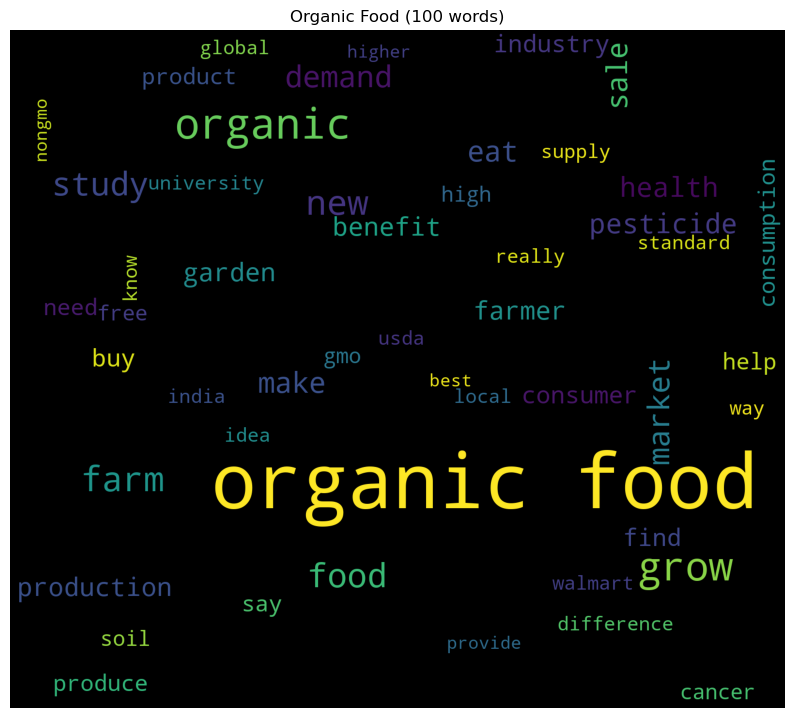

In [58]:
res = ' '.join([i for i in words_stopped if not i.isdigit()])

wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    height=1400,
    width=1600
).generate(res)

plt.figure(figsize=(10,12))
plt.imshow(wordcloud)
plt.title("Organic Food (100 words)")
plt.axis('off')
plt.show()

In [59]:
## Topic Modelling
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english',ngram_range=(1, 2))

dtm = vectorizer.fit_transform(content_score_data['processed_content'])

num_topics = 7
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

feature_names = vectorizer.get_feature_names_out()
top_words = 10

for topic_idx, topic in enumerate(lda.components_):
    print(f'Topic {topic_idx}')
    print(" ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()

Topic 0
food organic organic food new meet demand demand organic soaring soaring demand meet soaring

Topic 1
food organic food organic farming free study pesticide food farming food free stage

Topic 2
food organic organic food buy help demand demand organic local pesticide garden

Topic 3
organic food organic food study benefit health make organic make farmer eating

Topic 4
organic food organic food sale food sale food industry industry market standard global

Topic 5
organic organic food food product certified certified organic farm high new farming

Topic 6
organic food food organic seed leader farmer large suicide food scheme scheme dy



In [60]:
## Analysis for Negative Sentiments

negative_dataset = content_score_data[(content_score_data['sentiment_label'] == 'negative')]\
    .reset_index() \
        .drop(columns="index")

negative_dataset.sample(3)

,title,subreddit,score,id,url,comments,body,created,processed_content,neg,pos,neu,subjectivity,polarity,sentiment_label,cluster
33,Can Organic Food Prevent a Public Health Crisis?,organic,9,5ym5pl,http://civileats.com/2017/03/08/can-organic-fo...,1,NaN,1.489154e+09,organic food prevent public health crisis,0.446,0.120,0.435,0.066667,0.000000,negative,1
23,Organic Food Fights Back Against 'Non-GMO' Rival,organic,8,4w0tht,http://www.npr.org/sections/thesalt/2016/08/03...,2,NaN,1.470258e+09,organic food fight back nongmo rival,0.342,0.000,0.658,0.000000,0.000000,negative,1
47,"Sparks Fly, Organic Food in Jeopardy: Big Ag T...",OrganicFarming,0,24oong,http://eatdrinkbetter.com/2014/05/02/sparks-fl...,0,NaN,1.399199e+09,spark fly organic food jeopardy big ag take na...,0.194,0.119,0.688,0.333333,0.266667,negative,1


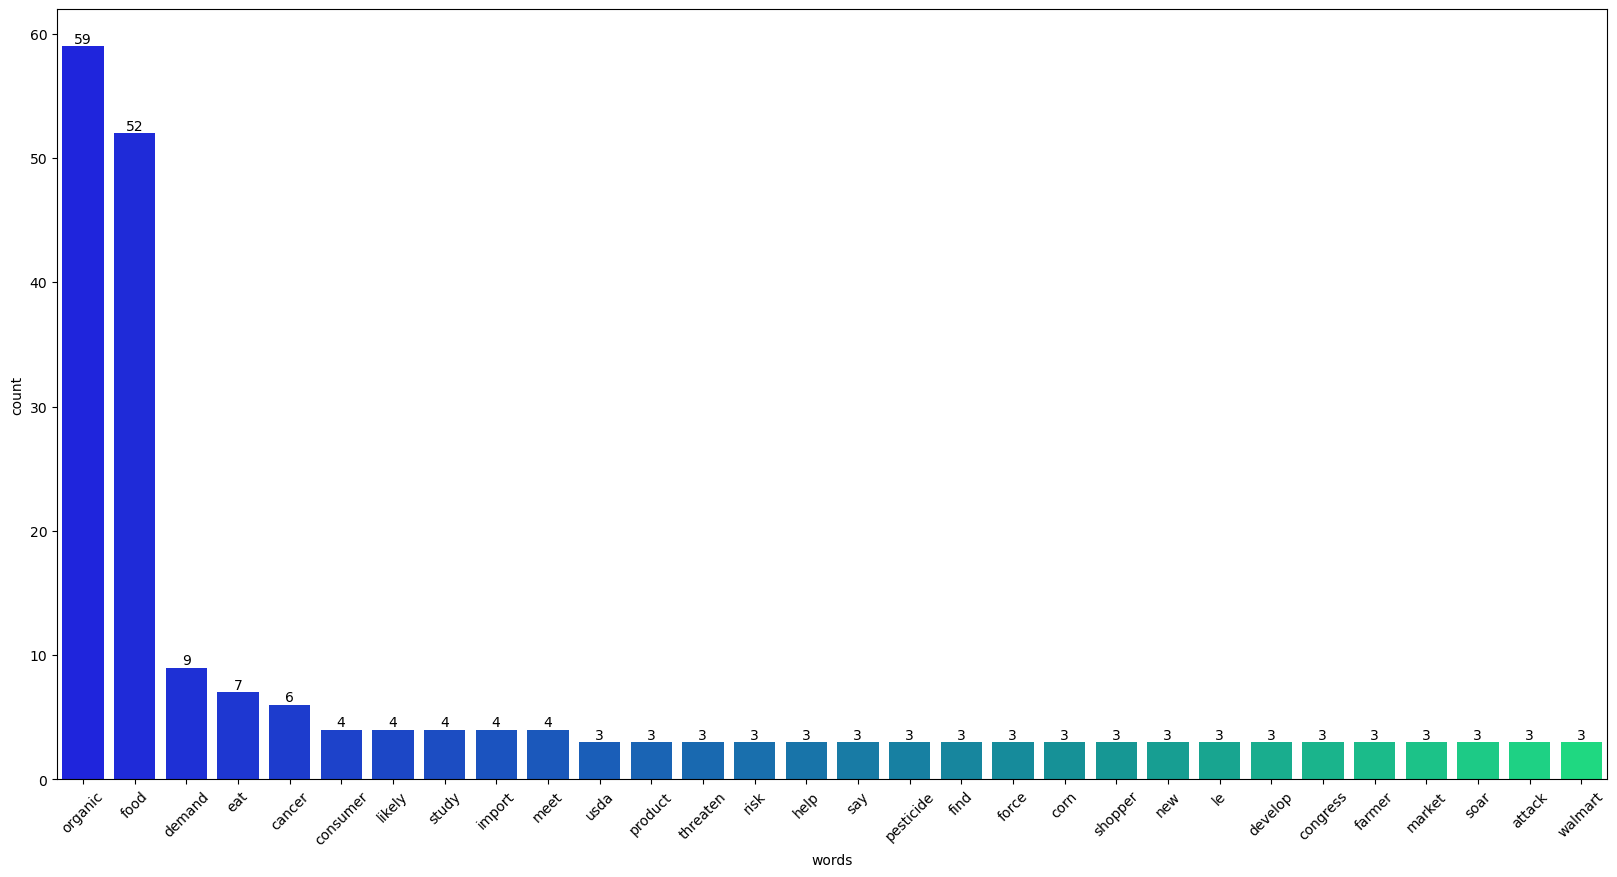

In [61]:
words_stopped = process_content_text(negative_dataset['processed_content'])
content_tostring = " ".join(words_stopped)

counter = Counter(content_tostring.split())
most_frequent = counter.most_common(30)

fig = plt.figure(figsize=(20, 10))
_ = pd.DataFrame(most_frequent, columns=("words", "count"))
ax = sns.barplot(x="words", y = "count", data=_, palette="winter")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()

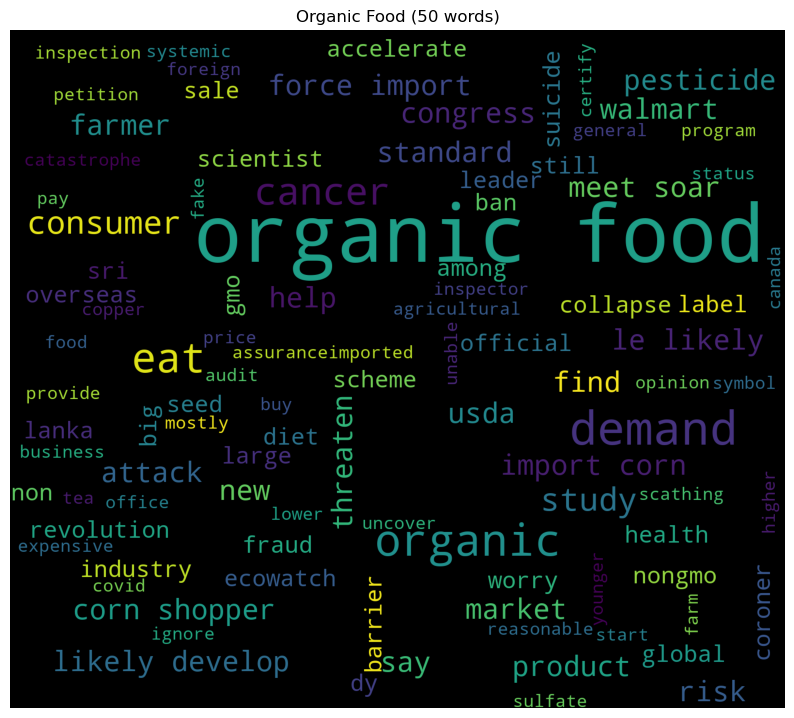

In [63]:
res = ' '.join([i for i in words_stopped if not i.isdigit()])

wordcloud = WordCloud(
    background_color='black',
    max_words=100,
    height=1400,
    width=1600
).generate(res)

plt.figure(figsize=(10,12))
plt.imshow(wordcloud)
plt.title("Organic Food (50 words)")
plt.axis('off')
plt.show()

In [64]:
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english',ngram_range=(1, 2))

dtm = vectorizer.fit_transform(negative_dataset['processed_content'])

num_topics = 7
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

feature_names = vectorizer.get_feature_names_out()
top_words = 10

for topic_idx, topic in enumerate(lda.components_):
    print(f'Topic {topic_idx}')
    print(" ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()

Topic 0
food sale sale accelerate sale accelerate covid covid accelerates accelerates accelerates demand demand demand organic

Topic 1
organic organic food food standard eating help congress collapse non non organic

Topic 2
food organic food organic demand demand organic import corn shopper corn forced shopper demand

Topic 3
organic organic food food likely cancer le likely le develop likely develop study

Topic 4
organic food food organic cancer consumer barrier attack organic attack risk industry

Topic 5
organic food food organic walmart threatens walmart threatens threatens organic stanford trump conventional mainstream medium

Topic 6
organic food food organic farmer market new seed overseas product nongmo



### Comments Analysis

In [55]:
# comments = ast.literal_eval(content_data['comments'][0])
# comment_index = comment[0]
# comment_index

comment_count_list = []
for i in range(len(content_data['comments'])):
    comment_count = ast.literal_eval(content_data['comments'][i])
    comment_count_list.append(len(comment_count))
    
content_data['comment_count'] = comment_count_list

In [ ]:
#cleaned comments

dirty_comments = content_data['comments']
cleaned_comments = []
for i in range(len(dirty_comments)):
    cont_comments = ast.literal_eval(dirty_comments[i])
    clean_comment = [preprocess_text(cont_comment) for cont_comment in cont_comments]
    cleaned_comments.append(clean_comment)
    
cleaned_comments

In [58]:

content_data['processed_comments'] = cleaned_comments

In [60]:
content_data

0      [dated guy said ol eat meat uncle farm first d...
1      [food waste business majority household accord...
2      [, mine get tinned food breakfast supper dry f...
3      [yes potentially seen tree nut peanut allergy ...
4      [thread locked due excess rule violation sub r...
                             ...                        
258                                                   []
259    [anybody explain wwoofing free labor somebody ...
260    [dude totally try, super fun, oh forgot mentio...
261                                                   []
262    [sound great maybe little far away mass adopti...
Name: processed_comments, Length: 263, dtype: object

In [62]:
# comment_array = np.concatenate(content_data['processed_comments'])
merged_array = [element for array in content_data['processed_comments'] for element in array]

new_comment_data = get_sentiment_scores(merged_array)['scores']
comment_data = pd.DataFrame(new_comment_data)

In [63]:
comment_data.columns = ['neg', 'pos', 'neu']
comment_data['comments'] = merged_array
comment_data

,neg,pos,neu,comments
0,0.000,0.000,1.000,dated guy said ol eat meat uncle farm first da...
1,0.000,0.281,0.719,mean occasionally buy product smiling cartoon ...
2,0.286,0.113,0.601,think say much theyre trying tell right thing ...
3,0.241,0.074,0.685,know someone always post ‘ field fork ’ pictur...
4,0.140,0.271,0.589,think ’ lying people love think ’ consider rig...
...,...,...,...,...
1349,0.000,0.434,0.566,something similar month ago fun challenge coff...
1350,0.093,0.198,0.709,able complete community center challenge many ...
1351,0.000,0.000,1.000,yup access full catalog seed since still buy s...
1352,0.042,0.085,0.872,saw post decided give whirl however im playing...


In [ ]:
## Polarity and Subjectivity Scores for comments

comm_subjectivity_score = pd.Series(merged_array).apply(lambda x: TextBlob(x).sentiment.subjectivity)
comm_polarity_score = pd.Series(merged_array).apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
comment_data['polarity'] = comm_polarity_score 
comment_data['subjectivity'] = comm_subjectivity_score 
comment_data

,neg,pos,neu,comments,polarity,subjectivity
0,0.000,0.000,1.000,dated guy said ol eat meat uncle farm first da...,0.225000,0.366667
1,0.000,0.281,0.719,mean occasionally buy product smiling cartoon ...,-0.156250,0.406250
2,0.286,0.113,0.601,think say much theyre trying tell right thing ...,-0.071429,0.467460
3,0.241,0.074,0.685,know someone always post ‘ field fork ’ pictur...,-0.066667,0.133333
4,0.140,0.271,0.589,think ’ lying people love think ’ consider rig...,0.105952,0.347619
...,...,...,...,...,...,...
1349,0.000,0.434,0.566,something similar month ago fun challenge coff...,0.100000,0.533333
1350,0.093,0.198,0.709,able complete community center challenge many ...,0.250000,0.460648
1351,0.000,0.000,1.000,yup access full catalog seed since still buy s...,0.175000,0.275000
1352,0.042,0.085,0.872,saw post decided give whirl however im playing...,0.072222,0.522222


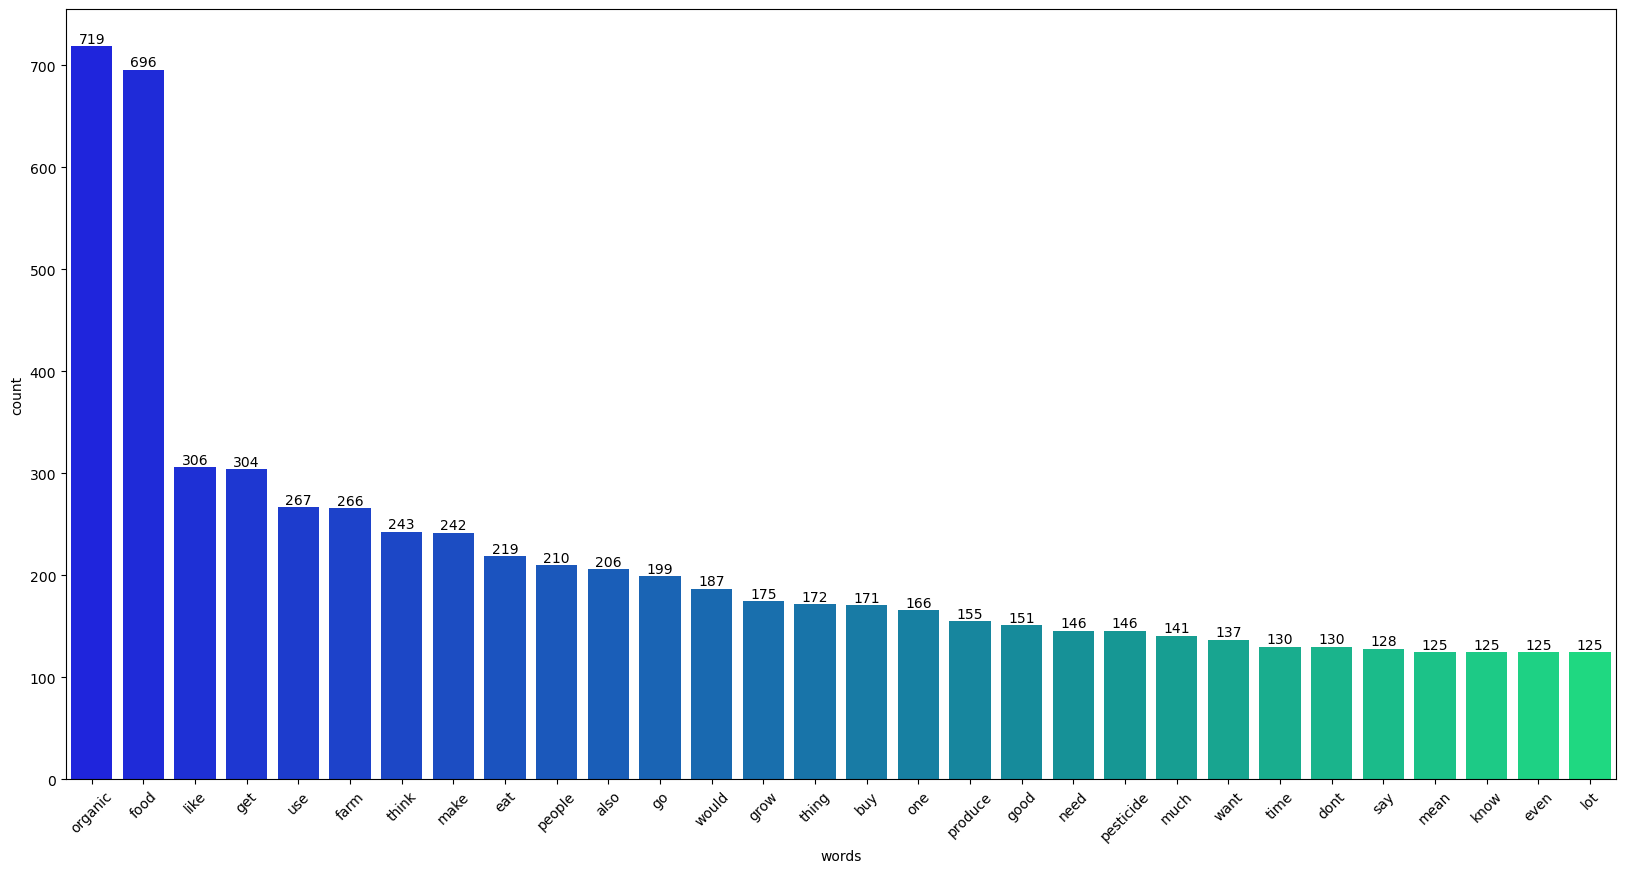

In [67]:
comment_stopwords = process_content_text(comment_data['comments'])

content_tostring = " ".join(comment_stopwords)

counter = Counter(content_tostring.split())
most_frequent = counter.most_common(30)

fig = plt.figure(figsize=(20, 10))
_ = pd.DataFrame(most_frequent, columns=("words", "count"))
ax = sns.barplot(x="words", y = "count", data=_, palette="winter")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()